In [1]:
import re

import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

from datetime import datetime, timedelta

matplotlib.rcParams.update({'font.size': 18})

In [2]:
file_loc = '../logs/generalisation/10-thesis-experiment-runs/measurement_solution.ilasp'
# file_loc = '../logs/generalisation/9-run_for_memory_experiment/sol_reduced.ilasp'
str_file = open(file_loc, 'r').read()

print(str_file[:50])

Time now is 23:04:34
Memory logs: 3667317  0.0  18


In [3]:
mem_measure_pattern = r'Time now is (\d\d:\d\d:\d\d) *\nMemory logs: +(\d+) +([\d.]+) +(\d+)'
# Do not capture terms
non_capture_mem_pattern = mem_measure_pattern.replace('(', '(?:')
memory_matches = re.findall(mem_measure_pattern, str_file)
memory_matches[:20]

[('23:04:34', '3667317', '0.0', '18108'),
 ('23:05:34', '3667317', '0.0', '218756'),
 ('23:06:34', '3667317', '0.0', '457628'),
 ('23:07:34', '3667317', '0.1', '1097456'),
 ('23:08:34', '3667317', '0.7', '4801720'),
 ('23:09:34', '3667317', '1.2', '7489976'),
 ('23:10:34', '3667317', '1.2', '7491256'),
 ('23:11:34', '3667317', '1.2', '7491256'),
 ('23:12:34', '3667317', '1.3', '8139444'),
 ('23:13:34', '3667317', '1.4', '8148664'),
 ('23:14:34', '3667317', '1.3', '7494584'),
 ('23:15:34', '3667317', '1.3', '7582084'),
 ('23:16:34', '3667317', '1.4', '8336020'),
 ('23:17:34', '3667317', '1.3', '7723492'),
 ('23:18:34', '3667317', '1.3', '8061152'),
 ('23:19:34', '3667317', '1.3', '7931360'),
 ('23:20:34', '3667317', '1.3', '7670240'),
 ('23:21:34', '3667317', '1.3', '7638736'),
 ('23:22:34', '3667317', '1.3', '7756340'),
 ('23:23:34', '3667317', '1.3', '7757620')]

In [4]:
int_w_default = lambda s: -1 if s == '' else int(s)

re_pattern = fr"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%% *Iteration (\d+) *%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%(?:\n{non_capture_mem_pattern})*
%% Searching for counterexample... *(?:\n%% New best score is  (\d+) *)?
%% Found (?:negative|positive) counterexample: ex_\d+_\d+ \(a total of \d+ counterexamples found\) *
%% Computed constraint. Now propagating to other examples... *
%% Constraint propagated to: \[.*\] *
%% Found hypothesis: \[.*\] \d+ *
([^I]*)
%% Iteration completed after ([\d.]+) seconds *
%% Iteration completed at (\d\d:\d\d:\d\d) *
"""
iteration_matches = re.findall(re_pattern, str_file)

print(len(iteration_matches))
iteration_matches

205


[('1',
  '',
  '%% in_generalised_sent(V1) :- dep(det,V3,V1); dep(nsubj,V2,V3). ',
  '104.7853217124939',
  '23:09:06'),
 ('2',
  '',
  '%% in_generalised_sent(V1) :- dep(dobj,V2,V1). \n%% in_generalised_sent(V1) :- dep(det,V3,V1); dep(nsubj,V2,V3). ',
  '182.16093468666077',
  '23:10:24'),
 ('3',
  '',
  '%% in_generalised_sent(V1) :- dep(dobj,V2,V1). \n%% in_generalised_sent(V1) :- in_generalised_sent(V2); dep(det,V2,V1). ',
  '252.27178692817688',
  '23:11:34'),
 ('4',
  '',
  '%% in_generalised_sent(V1) :- in_generalised_sent(V2); dep(det,V1,V2). \n%% in_generalised_sent(V1) :- in_generalised_sent(V2); dep(det,V2,V1). ',
  '319.3464443683624',
  '23:12:41'),
 ('5',
  '',
  '%% in_generalised_sent(V1) :- in_generalised_sent(V2); dep(det,V1,V2). \n%% 0 {in_generalised_sent(V1) } 1 :- dep(det,V2,V1). ',
  '395.86200761795044',
  '23:13:58'),
 ('6',
  '',
  '%% in_generalised_sent(V1) :- dep(nsubj,V1,V2). \n%% in_generalised_sent(V1) :- in_generalised_sent(V2); dep(det,V1,V2). \n%% 0 {

In [5]:
def to_time(data, time_col):
    data['day'] = 0
    for i, (prev, curr) in enumerate(zip(data[time_col], data[time_col][1:])):
        prev_date = datetime.strptime(prev, "%H:%M:%S")
        curr_date = datetime.strptime(curr, "%H:%M:%S")
        if curr_date < prev_date:
            data.loc[i + 1:, 'day'] += 1

    data[time_col] = [datetime.strptime(t, "%H:%M:%S") + timedelta(days=days) for t, days
                      in zip(data[time_col], data['day'])]
    del data['day']


sec_to_hour_div = 3600

# Create pandas tables from parsed data

In [6]:
to_gb_mult = 1024 ** 2

memory_data = pd.DataFrame(memory_matches, columns=['measurement_time', 'pid', 'memory_percent', 'memory'])
memory_data['pid'] = pd.to_numeric(memory_data['pid'])
memory_data['memory_percent'] = pd.to_numeric(memory_data['memory_percent'])
memory_data['memory'] = pd.to_numeric(memory_data['memory'])
memory_data['memory'] /= to_gb_mult

to_time(memory_data, time_col='measurement_time')

In [7]:
iteration_data = pd.DataFrame(iteration_matches,
                              columns=['iteration_num', 'best_score', 'hypothesis', 'elapsed_time', 'finish_time'])
# Replace field with just spaces with -1
iteration_data = iteration_data.replace(r'^\s*$', "-1", regex=True)

iteration_data['best_score'] = pd.to_numeric(iteration_data['best_score'])
iteration_data['iteration_num'] = pd.to_numeric(iteration_data['iteration_num'])
iteration_data['elapsed_time'] = pd.to_numeric(iteration_data['elapsed_time'])
iteration_data['elapsed_time'] /= sec_to_hour_div

to_time(iteration_data, time_col='finish_time')

In [8]:
def to_hours(time_delta):
    return time_delta.days * 24 + time_delta.seconds / 3600

0.0


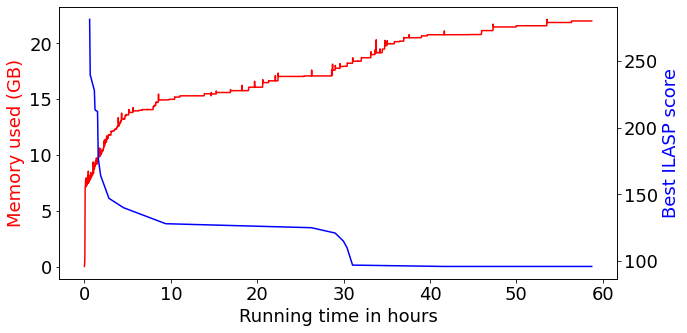

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

start_time = memory_data['measurement_time'].iloc[0]

time_passed_memory = (memory_data['measurement_time'] - start_time).map(to_hours)
print(time_passed_memory[0])
ax1.plot(time_passed_memory, memory_data['memory'], color='r')

filtered_iteration_data = iteration_data[iteration_data['best_score'] != -1]
last_row = pd.DataFrame(filtered_iteration_data.iloc[[-1]], columns=filtered_iteration_data.columns)
last_row['finish_time'] = memory_data['measurement_time'].iloc[-1]
filtered_iteration_data = pd.concat([filtered_iteration_data, last_row])
time_passed_best_score = (filtered_iteration_data['finish_time'] - start_time).map(to_hours)
ax2.plot(time_passed_best_score, filtered_iteration_data['best_score'], color='b')

ax1.set_xlabel('Running time in hours')
ax1.set_ylabel('Memory used (GB)', color='r')
ax2.set_ylabel('Best ILASP score', color='b')

plt.savefig("generalisation_memory_vs_best_score.png")
plt.show()

In [10]:
atomisation_file = '../logs/atomisation/2-thesis-experiment-runs/measurement_solution.ilasp'
atomisation_str_file = open(atomisation_file, 'r').read()

memory_matches = re.findall(mem_measure_pattern, atomisation_str_file)

memory_data = pd.DataFrame(memory_matches, columns=memory_data.columns)
memory_data['pid'] = pd.to_numeric(memory_data['pid'])
memory_data['memory_percent'] = pd.to_numeric(memory_data['memory_percent'])
memory_data['memory'] = pd.to_numeric(memory_data['memory'])
memory_data['memory'] /= to_gb_mult

to_time(memory_data, time_col='measurement_time')

In [11]:
atomisation_pattern = fr"""{re_pattern}
%% Example penalties are: *(\d+) *
%% Curr expected score: *(\d+) *
"""

iteration_matches = re.findall(atomisation_pattern, atomisation_str_file)
print(len(iteration_matches))
iteration_matches[:10]

1004


[('1',
  '',
  '%% splitting_tag(conj). ',
  '232.38575744628906',
  '10:12:46',
  '255',
  '1'),
 ('2',
  '',
  '%% in_atomic_sent(V1) :- in_atomic_sent(V2); dep(det, V2, V1). ',
  '400.03175377845764',
  '10:15:34',
  '255',
  '3'),
 ('3',
  '',
  '%% in_atomic_sent(V1) :- in_atomic_sent(V2); dep(dobj, V2, V1). ',
  '575.6904764175415',
  '10:18:29',
  '255',
  '3'),
 ('4', '', '%% ', '758.285483121872', '10:21:32', '255', '4'),
 ('5',
  '',
  '%% splitting_tag(conj). ',
  '995.703462600708',
  '10:25:29',
  '251',
  '4'),
 ('6',
  '',
  '%% splitting_tag(conj). \n%% in_atomic_sent(V1) :- in_atomic_sent(V2); dep(det, V2, V1). ',
  '1150.2386059761047',
  '10:28:04',
  '252',
  '4'),
 ('7',
  '',
  '%% splitting_tag(conj). ',
  '1323.245624780655',
  '10:30:57',
  '255',
  '5'),
 ('8',
  '',
  '%% splitting_tag(conj). \n%% in_atomic_sent(V1) :- in_atomic_sent(V2); dep(dobj, V2, V1). ',
  '1412.5489819049835',
  '10:32:26',
  '251',
  '5'),
 ('9',
  '',
  '%% splitting_tag(conj). \n%% 

In [12]:
iteration_data = pd.DataFrame(iteration_matches,
                              columns=['iteration_num', 'best_score', 'hypothesis', 'elapsed_time', 'finish_time',
                                       'example_penalties', 'hypothesis_penalty'])
# Replace field with just spaces with -1
iteration_data = iteration_data.replace(r'^\s*$', "-1", regex=True)

iteration_data['best_score'] = pd.to_numeric(iteration_data['best_score'])
iteration_data['iteration_num'] = pd.to_numeric(iteration_data['iteration_num'])
iteration_data['elapsed_time'] = pd.to_numeric(iteration_data['elapsed_time'])
iteration_data['elapsed_time'] /= sec_to_hour_div
iteration_data['example_penalties'] = pd.to_numeric(iteration_data['example_penalties'])
iteration_data['hypothesis_penalty'] = pd.to_numeric(iteration_data['hypothesis_penalty'])

to_time(iteration_data, time_col='finish_time')

0.0


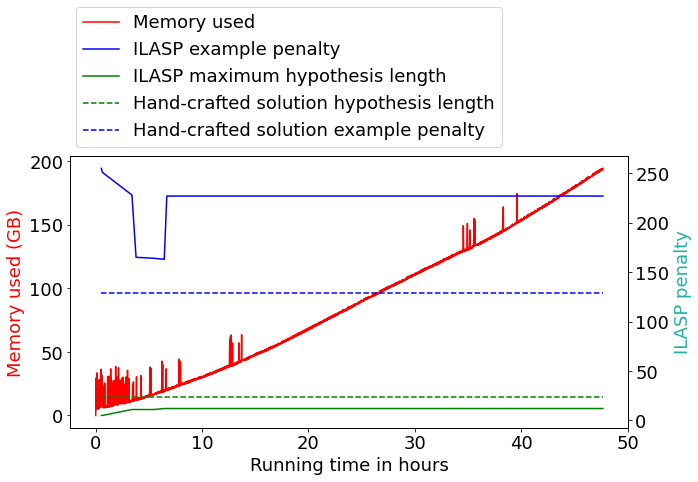

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

start_time = memory_data['measurement_time'].iloc[0]

time_passed_memory = (memory_data['measurement_time'] - start_time).map(to_hours)
print(time_passed_memory[0])
ax1.plot(time_passed_memory, memory_data['memory'], color='r', label='Memory used')

filtered_iteration_data = iteration_data[iteration_data['best_score'] != -1]
last_row = pd.DataFrame(filtered_iteration_data.iloc[[-1]], columns=filtered_iteration_data.columns)
last_row['finish_time'] = memory_data['measurement_time'].iloc[-1]
filtered_iteration_data = pd.concat([filtered_iteration_data, last_row])
time_passed_best_score = (filtered_iteration_data['finish_time'] - start_time).map(to_hours)
ax2.plot(time_passed_best_score, filtered_iteration_data['example_penalties'], color='b', label='ILASP example penalty')
ax2.plot(time_passed_best_score, filtered_iteration_data['hypothesis_penalty'], color='g',
         label='ILASP maximum hypothesis length')

hand_crafted_sol_prior_pen = 24
ax2.hlines(y=hand_crafted_sol_prior_pen, xmin=time_passed_best_score.iloc[0], xmax=time_passed_best_score.iloc[-1],
           color='g', linestyle='--', label='Hand-crafted solution hypothesis length')
hand_crafted_sol_example_pen = 129
ax2.hlines(y=hand_crafted_sol_example_pen, xmin=time_passed_best_score.iloc[0], xmax=time_passed_best_score.iloc[-1],
           color='b', linestyle='--', label='Hand-crafted solution example penalty')

fig.legend(loc='upper left', bbox_to_anchor=(0.12, 1.32, 0, 0))
# 24, 77

ax1.set_xlabel('Running time in hours')
ax1.set_ylabel('Memory used (GB)', color='r')
ax2.set_ylabel('ILASP penalty', color='lightseagreen')

plt.savefig("atomisation_memory_vs_best_score.png", bbox_inches='tight')
plt.show()
